In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
os.environ['TAVILY_API_KEY'] = os.getenv("TAVILY_API_KEY")

### Langsmith tracking
os.environ['LANGCHAIN_API_KEY'] = os.getenv("LANGCHAIN_API_KEY")
os.environ['LANGCHAIN_TRACING_V2'] = "true"
os.environ['LANGCHAIN_PROJECT'] = os.getenv("LANGCHAIN_PROJECT")

In [2]:
### initialize the llm model
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")

In [9]:
import operator
from typing import Annotated, List
from typing_extensions import TypedDict, Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage

In [5]:
# Graph State 
class State(TypedDict):
    joke:str
    topic: str
    feedback: str
    funny_or_not: str

In [10]:
# Schema for structure output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(description="Decide if the joke is funny or not.")
    feedback: str = Field(description="if the joke is not funny, provide feedback on how to improve it.")

In [11]:
# Augment the LLM with schema for structure output 
evaluator = llm.with_structured_output(Feedback)

In [13]:
## Defining the Node

def llm_call_generator(state:State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state["topic"]} but take into account the feedback: {state["feedback"]}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state["topic"]}")
    return {"joke":msg.content}


def llm_call_evaluator(state:State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state["joke"]}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evalutor
def route_joke(state:State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"

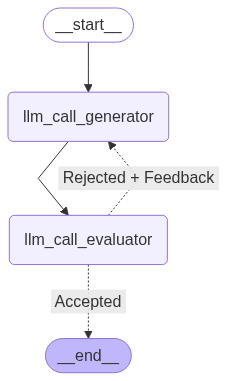

In [14]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

## Creating the graph
builder = StateGraph(State)

## Adding the Node
builder.add_node("llm_call_generator", llm_call_generator)
builder.add_node("llm_call_evaluator", llm_call_evaluator)

## Adding the Edges
builder.add_edge(START, "llm_call_generator")
builder.add_edge("llm_call_generator", "llm_call_evaluator")
builder.add_conditional_edges(
    "llm_call_evaluator", route_joke, {
        "Accepted": END,
        "Rejected + Feedback" : "llm_call_generator"
    }
)

## Compile the Graph
graph_builder = builder.compile()

## View the Graph
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [15]:
state = {"topic":"friend"}
result = graph_builder.invoke(state)
result

{'joke': 'Why did the math book look sad at the party?\n\nBecause it had too many "problems," but thankfully it had a friend like you to help solve them!',
 'topic': 'friend',
 'feedback': "This joke effectively uses a classic play on words, mixing a relatable emotion (being 'sad') with a mathematical pun ('problems'). The addition of a positive twist with 'a friend like you to help solve them' adds a heartwarming touch, enhancing its appeal.",
 'funny_or_not': 'funny'}